Librerías necesarias:

In [3]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import csv
#from scipy import stats
#KERAS
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
#np.set_printoptions(threshold=np.inf)
from keras.models import model_from_json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

Leemos el directorio y contamos cuántas imágenes hay

In [4]:
directoris = []
contador = []
fitxers = []
path_img = []

#Devuelve el path a las imágenes (path_img), el nombre de las imágenes (fitxers) y la cantidad (contador)
for dirname, _, filenames in os.walk('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train_images',followlinks=False):
    directoris.append(os.path.join(dirname))
    for i in filenames:
        if not '._' in i:
            fitxers.append(i)
            path_img.append(dirname+"/"+i)
    contador.append(dirname+': CONTIENE '+str(len(fitxers)) + ' FOTOS')

In [5]:
contador

['/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train_images: CONTIENE 3662 FOTOS']

In [4]:
# Para mirar si coinciden el nombre de los ficheros con los reales
#df = pd.DataFrame(fitxers)
#df.to_csv(r'noms_train_images2.csv')

In [5]:
# Cargamos el train.csv
csv_train = open('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train.csv')
csvreader = csv.reader(csv_train)
rows = []
for row in csvreader:
        rows.append(row)

In [50]:
#Observamos las primeras líneas del fichero csv
rows[0:10]

[['id_code;diagnosis'],
 ['000c1434d8d7;2'],
 ['001639a390f0;4'],
 ['0024cdab0c1e;1'],
 ['002c21358ce6;0'],
 ['005b95c28852;0'],
 ['0083ee8054ee;4'],
 ['0097f532ac9f;0'],
 ['00a8624548a9;2'],
 ['00b74780d31d;2']]

Observamos que hay algunos nombres de imagen en el fichero de csv train con las etiquetas que no coinciden con el nombre del fichero realmente, por lo que algunas imágenes no sabremos qué etiqueta tienen. 
Además cuando leemos la carpeta de imágenes nos duplica los ficheros y nos cuenta como el doble de imágenes. 

Creamos los sets de imágens y etiquetas

In [6]:
data = []
labels = []
# recorremos los paths de las imágenes y de las filas del csv, buscamos el nombre de la imágen en el
#csv y creamos dos sets de datos con las imágenes y la etiqueta correspondiente en la misma posición
for imagePath in path_img:
    #print(imagePath)
    if not '._' in imagePath:
        for row in rows:
            item = imagePath.split(os.path.sep)[-1]
            if item[0:item.find('.')] in row[0] and item[1]!='_' :
                # leemos la imagen
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
                # creamos los arrays de imágenes y etiquetas
                data.append(image)
                labels.append(row[0][(row[0].find(';'))+1:])

In [70]:
print(f'Tamaño de los datos: {len(data)}')

Tamaño de los datos: 3648


Mostramos una imagen de cada etiqueta

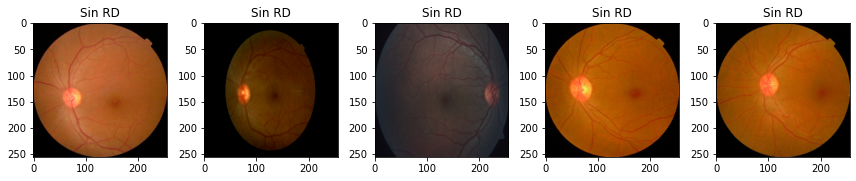

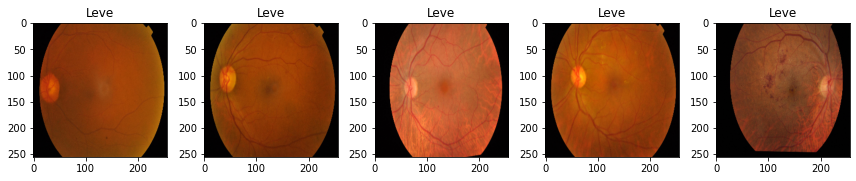

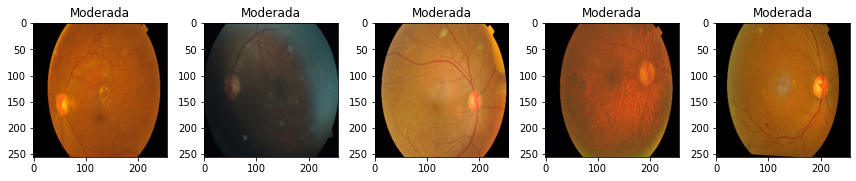

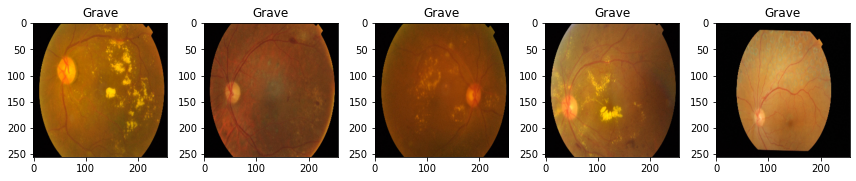

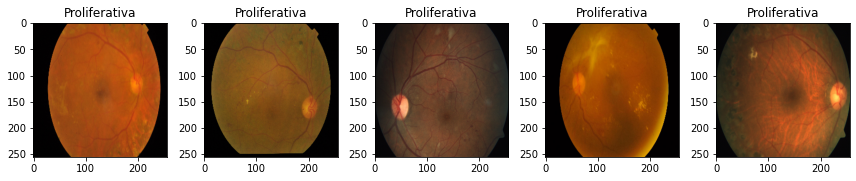

In [72]:
ax, fig = plt.subplots(5, figsize=(12,5))
id_0 = 0
for i in range(5):
    plt.subplot(1, 5, i+1)
    id_0 = (labels.index('0', id_0+1))
    plt.imshow(cv2.cvtColor(data[id_0], cv2.COLOR_BGR2RGB))
    plt.title('Sin RD')
plt.tight_layout()    

ax, fig = plt.subplots(5, figsize=(12,5))
id_1 = 0
for i in range(5):
    plt.subplot(1, 5, i+1)
    id_1 = (labels.index('1', id_1+1))
    plt.imshow(cv2.cvtColor(data[id_1], cv2.COLOR_BGR2RGB))
    plt.title('Leve')
plt.tight_layout()

ax, fig = plt.subplots(5, figsize=(12,5))
id_2 = 0
for i in range(5):
    plt.subplot(1, 5, i+1)
    id_2 = (labels.index('2', id_2+1))
    plt.imshow(cv2.cvtColor(data[id_2], cv2.COLOR_BGR2RGB))
    plt.title('Moderada')
plt.tight_layout()    

ax, fig = plt.subplots(5, figsize=(12,5))
id_3 = 0
for i in range(5):
    plt.subplot(1, 5, i+1)
    id_3 = (labels.index('3', id_3+1))
    plt.imshow(cv2.cvtColor(data[id_3], cv2.COLOR_BGR2RGB))
    plt.title('Grave')
plt.tight_layout()    

ax, fig = plt.subplots(5, figsize=(12,5))
id_4 = 0
for i in range(5):
    plt.subplot(1, 5, i+1)
    id_4 = (labels.index('4', id_4+1))
    plt.imshow(cv2.cvtColor(data[id_4], cv2.COLOR_BGR2RGB))
    plt.title('Proliferativa')
plt.tight_layout()    



(-0.5, 255.5, 255.5, -0.5)

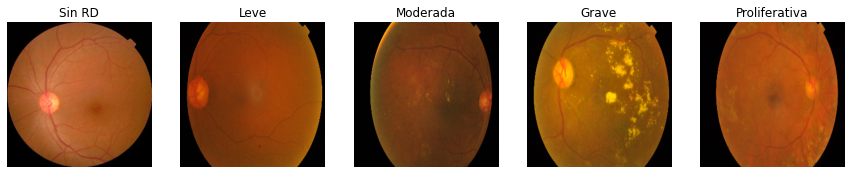

In [18]:
#plt.figure(figsize=[15, 15])
f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
id_0 = labels.index('0')
id_1 = labels.index('1')
id_2 = labels.index('2')
id_3 = labels.index('3')
id_4 = labels.index('4')
axarr[0].imshow(cv2.cvtColor(data[id_0], cv2.COLOR_BGR2RGB))
axarr[0].title.set_text('Sin RD')
axarr[0].axis('off')
axarr[1].imshow(cv2.cvtColor(data[id_1], cv2.COLOR_BGR2RGB))
axarr[1].title.set_text('Leve')
axarr[1].axis('off')
axarr[2].imshow(cv2.cvtColor(data[id_2], cv2.COLOR_BGR2RGB))
axarr[2].title.set_text('Moderada')
axarr[2].axis('off')
axarr[3].imshow(cv2.cvtColor(data[id_3], cv2.COLOR_BGR2RGB))
axarr[3].title.set_text('Grave')
axarr[3].axis('off')
axarr[4].imshow(cv2.cvtColor(data[id_4], cv2.COLOR_BGR2RGB))
axarr[4].title.set_text('Proliferativa')
axarr[4].axis('off')

In [19]:
#Función que recorta los bordes de las imágenes 
#(inspirado en  https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping)
def crop_border(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img > 7       
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        img = np.stack([img1,img2,img3],axis=-1)
    return img


Provamos con tres tipos de filtros diferentes (equalización del histograma, aplicación de un filtro gausiano y la extracción del canal verde con CLAHE)

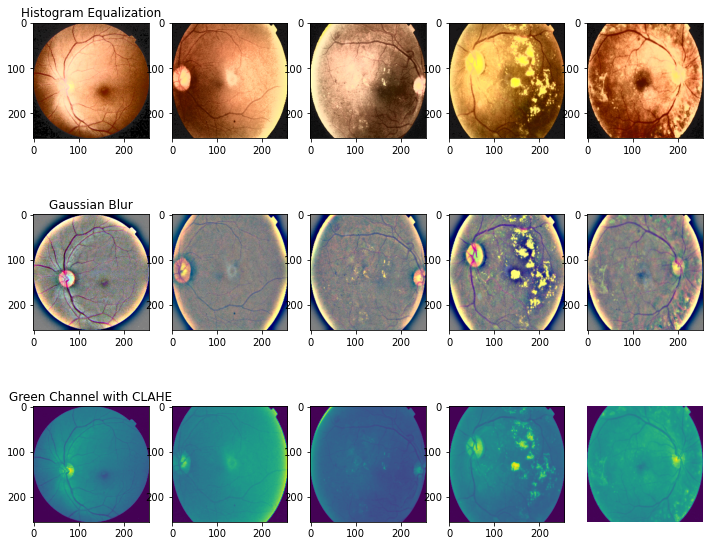

In [20]:
images_example = [data[id_0],data[id_1],data[id_2],data[id_3],data[id_4]]
width = 256
height = 256
equ_images = []
gaus_images = []
green = []
for i in images_example:
    image = i
    image = crop_border(image)
    image = cv2.resize(image, (width, height))
    
    #Applying histogram equalization
    img_to_yuv = cv2.cvtColor(image,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    
    # Applying GaussianBlur
    blurred = cv2.blur(image, ksize=(int(width / 6), int(height / 6)))
    image_blur = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    
    #Extract green channel
    green_channel = image[:,:,1]
    clipLimit = 2.0
    tileGridSize = (8,8)
    clahe=cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
    cla=clahe.apply(green_channel)
    #     cla=clahe.apply(cla)
    img=cv2.merge((cla,cla,cla))
    
    equ_images.append(hist_equalization_result)
    gaus_images.append(image_blur)
    green.append(green_channel)

f, axarr = plt.subplots(3,5,figsize=(12, 10))
plt.axis('off')
axarr[0,0].title.set_text('Histogram Equalization')
axarr[0,0].imshow(cv2.cvtColor(equ_images[0], cv2.COLOR_BGR2RGB))
axarr[0,1].imshow(cv2.cvtColor(equ_images[1], cv2.COLOR_BGR2RGB))
axarr[0,2].imshow(cv2.cvtColor(equ_images[2], cv2.COLOR_BGR2RGB))
axarr[0,3].imshow(cv2.cvtColor(equ_images[3], cv2.COLOR_BGR2RGB))
axarr[0,4].imshow(cv2.cvtColor(equ_images[4], cv2.COLOR_BGR2RGB))
axarr[1,0].title.set_text('Gaussian Blur')
axarr[1,0].imshow(cv2.cvtColor(gaus_images[0], cv2.COLOR_BGR2RGB))
axarr[1,1].imshow(cv2.cvtColor(gaus_images[1], cv2.COLOR_BGR2RGB))
axarr[1,2].imshow(cv2.cvtColor(gaus_images[2], cv2.COLOR_BGR2RGB))
axarr[1,3].imshow(cv2.cvtColor(gaus_images[3], cv2.COLOR_BGR2RGB))
axarr[1,4].imshow(cv2.cvtColor(gaus_images[4], cv2.COLOR_BGR2RGB))
axarr[2,0].title.set_text('Green Channel with CLAHE')
axarr[2,0].imshow(green[0])
axarr[2,1].imshow(green[1])
axarr[2,2].imshow(green[2])
axarr[2,3].imshow(green[3])
axarr[2,4].imshow(green[4])

Como vemos que el con el filtro gausiano es con el que obtenemos un resalte mayor de las anomalías y los vasos de la retina, aplicamos este a todo el set de datos

In [21]:
processed_data = []

for img in data:
    image = img
    image = crop_border(image)
            
    image = cv2.resize(image, (256, 256))
    
    # Applying GaussianBlur
    blurred = cv2.blur(image, ksize=(int(256 / 6), int(256 / 6)))
    image_blur = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    
    processed_data.append(image_blur)

Mostramos los histogramas de 10 imágenes antes y después del procesado

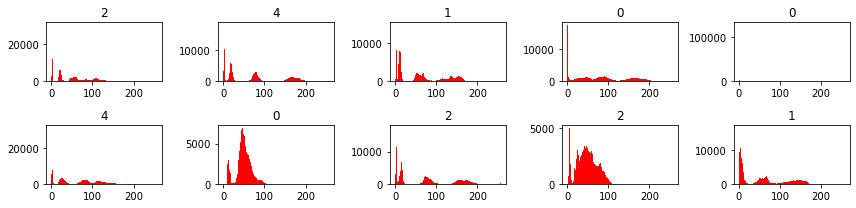

In [28]:
ax, fig=plt.subplots(2*5,figsize=(12, 3))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.hist(data[i].flatten(),256,[0,256],color='r')
    plt.title(labels[i])

plt.tight_layout()    

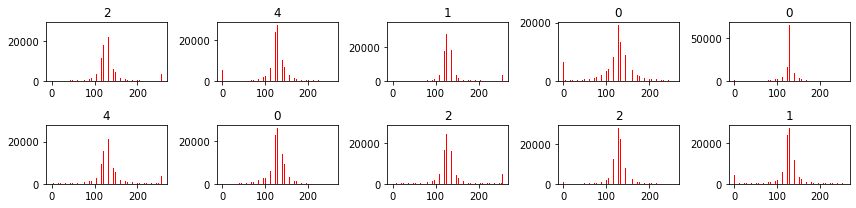

In [29]:
ax, fig=plt.subplots(2*5,figsize=(12, 3))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.hist(processed_data[i].flatten(),256,[0,256],color='r')
    plt.title(labels[i])
    
plt.tight_layout()    

Miramos la cantidad de imágenes que hay con cada etiqueta

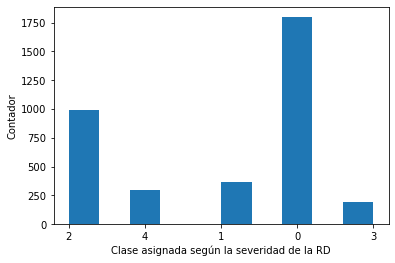

In [51]:
#ANALIZANDO DATOS
plt.hist(labels)
plt.xlabel("Clase asignada según la severidad de la RD")
plt.ylabel("Contador")
plt.show()


In [271]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'0': 1796, '1': 369, '2': 995, '3': 193, '4': 295}